<a href="https://colab.research.google.com/github/dingBatman01/titanic_r/blob/main/Titanic_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages('BiocManager')
BiocManager::install('VIM')
library(VIM)

In [ ]:
install.packages(c("dplyr", "randomForest"))
library(dplyr)
library(randomForest)

In [14]:
# Import Raw Data
system("gdown --id 1viGX5VQm2jXq1SsPJHWkLe0SHd7yDpK3")
t_test <- readr::read_csv("test.csv")
system("gdown --id 1Y8SPwThswMBTBxT9QHDFkFWJXuT9YLal")
t_train <- readr::read_csv("train.csv")
names(t_test)
names(t_train)


── Column specification ────────────────────────────────────────────────────────
cols(
  PassengerId = col_double(),
  Pclass = col_double(),
  Name = col_character(),
  Gender = col_character(),
  Age = col_double(),
  SibSp = col_double(),
  Parch = col_double(),
  Ticket = col_character(),
  Fare = col_double(),
  Cabin = col_character(),
  Embarked = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  PassengerId = col_double(),
  Survived = col_double(),
  Pclass = col_double(),
  Name = col_character(),
  Gender = col_character(),
  Age = col_double(),
  SibSp = col_double(),
  Parch = col_double(),
  Ticket = col_character(),
  Fare = col_double(),
  Cabin = col_character(),
  Embarked = col_character()
)




[1] "PassengerId" "Pclass"      "Name"        "Gender"      "Age"        
 [6] "SibSp"       "Parch"       "Ticket"      "Fare"        "Cabin"      
[11] "Embarked"

[1] "PassengerId" "Survived"    "Pclass"      "Name"        "Gender"     
 [6] "Age"         "SibSp"       "Parch"       "Ticket"      "Fare"       
[11] "Cabin"       "Embarked"

Since "test.csv" file is the test set that we need to test our model with, it does not have "Survived" column.   
Anyway, I want to combine these two sets and make sure if the data sets have any missing values, or I need to do any data pre-processing.

In [15]:
# Combining train and test sets
t_full <- dplyr::bind_rows(t_train, t_test)
summary(t_full)

  PassengerId      Survived          Pclass          Name          
 Min.   :   1   Min.   :0.0000   Min.   :1.000   Length:1309       
 1st Qu.: 328   1st Qu.:0.0000   1st Qu.:2.000   Class :character  
 Median : 655   Median :0.0000   Median :3.000   Mode  :character  
 Mean   : 655   Mean   :0.3838   Mean   :2.295                     
 3rd Qu.: 982   3rd Qu.:1.0000   3rd Qu.:3.000                     
 Max.   :1309   Max.   :1.0000   Max.   :3.000                     
                NA's   :418                                        
    Gender               Age            SibSp            Parch      
 Length:1309        Min.   : 0.17   Min.   :0.0000   Min.   :0.000  
 Class :character   1st Qu.:21.00   1st Qu.:0.0000   1st Qu.:0.000  
 Mode  :character   Median :28.00   Median :0.0000   Median :0.000  
                    Mean   :29.88   Mean   :0.4989   Mean   :0.385  
                    3rd Qu.:39.00   3rd Qu.:1.0000   3rd Qu.:0.000  
                    Max.   :80.00   Max.  

(I was originally using "rbind()" function, but one of the references that I checked says "dplyr::bind_rows()" allows you not to worry about dimensions of the two data sets.  
Therefore, I didn't need to make "Survived" column in the test set and fill the column with "NA's".  
It automatically does it for me.)


In [16]:
# Changing some variables into factors and checking for NA 
str(t_full)
summary(t_full)
t_full <- t_full %>% 
            mutate(Survived = factor(Survived),
                   Pclass = factor(Pclass, ordered = T),
                   Name = factor(Name),
                   Gender = factor(Gender),
                   Cabin = factor(Cabin),
                   Embarked = factor(Embarked))
str(t_full)
summary(t_full)

spec_tbl_df[,12] [1,309 × 12] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ PassengerId: num [1:1309] 1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : num [1:1309] 0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : num [1:1309] 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr [1:1309] "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Gender     : chr [1:1309] "male" "female" "female" "female" ...
 $ Age        : num [1:1309] 22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : num [1:1309] 1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : num [1:1309] 0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr [1:1309] "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num [1:1309] 7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr [1:1309] NA "C85" NA "C123" ...
 $ Embarked   : chr [1:1309] "S" "C" "S" "S" ...
 - attr(*, "spec")=
  .. cols(
  ..   PassengerId = col_double(),
  ..   Survived = col_double(),
  ..   P

  PassengerId      Survived          Pclass          Name          
 Min.   :   1   Min.   :0.0000   Min.   :1.000   Length:1309       
 1st Qu.: 328   1st Qu.:0.0000   1st Qu.:2.000   Class :character  
 Median : 655   Median :0.0000   Median :3.000   Mode  :character  
 Mean   : 655   Mean   :0.3838   Mean   :2.295                     
 3rd Qu.: 982   3rd Qu.:1.0000   3rd Qu.:3.000                     
 Max.   :1309   Max.   :1.0000   Max.   :3.000                     
                NA's   :418                                        
    Gender               Age            SibSp            Parch      
 Length:1309        Min.   : 0.17   Min.   :0.0000   Min.   :0.000  
 Class :character   1st Qu.:21.00   1st Qu.:0.0000   1st Qu.:0.000  
 Mode  :character   Median :28.00   Median :0.0000   Median :0.000  
                    Mean   :29.88   Mean   :0.4989   Mean   :0.385  
                    3rd Qu.:39.00   3rd Qu.:1.0000   3rd Qu.:0.000  
                    Max.   :80.00   Max.  

spec_tbl_df[,12] [1,309 × 12] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ PassengerId: num [1:1309] 1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass     : Ord.factor w/ 3 levels "1"<"2"<"3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 156 287 531 430 23 826 775 922 613 855 ...
 $ Gender     : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num [1:1309] 22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : num [1:1309] 1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : num [1:1309] 0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr [1:1309] "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num [1:1309] 7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 186 levels "A10","A11","A14",..: NA 107 NA 71 NA NA 164 NA NA NA ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 - attr(*, "spec")=
  .. cols(
  ..   PassengerId = col_double(),
  .. 

  PassengerId   Survived   Pclass                                Name     
 Min.   :   1   0   :549   1:323   Connolly, Miss. Kate            :   2  
 1st Qu.: 328   1   :342   2:277   Kelly, Mr. James                :   2  
 Median : 655   NA's:418   3:709   Abbing, Mr. Anthony             :   1  
 Mean   : 655                      Abbott, Master. Eugene Joseph   :   1  
 3rd Qu.: 982                      Abbott, Mr. Rossmore Edward     :   1  
 Max.   :1309                      Abbott, Mrs. Stanton (Rosa Hunt):   1  
                                   (Other)                         :1301  
    Gender         Age            SibSp            Parch      
 female:466   Min.   : 0.17   Min.   :0.0000   Min.   :0.000  
 male  :843   1st Qu.:21.00   1st Qu.:0.0000   1st Qu.:0.000  
              Median :28.00   Median :0.0000   Median :0.000  
              Mean   :29.88   Mean   :0.4989   Mean   :0.385  
              3rd Qu.:39.00   3rd Qu.:1.0000   3rd Qu.:0.000  
              Max.   :

In order to run codes, I need to change character variables to factor variables.


 Variables sorted by number of missings: 
    Variable Count
       Cabin  1014
    Survived   418
         Age   263
    Embarked     2
        Fare     1
 PassengerId     0
      Pclass     0
        Name     0
      Gender     0
       SibSp     0
       Parch     0
      Ticket     0


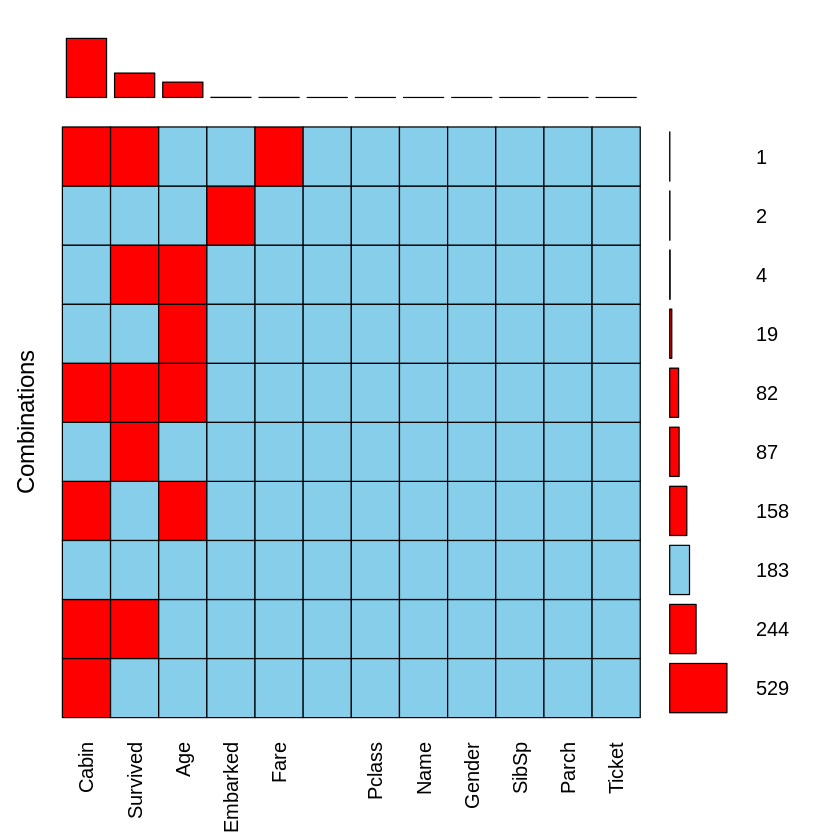

In [17]:
# Checking for Missing Values using VIM package
VIM::aggr(t_full, prop = FALSE, combined = TRUE, numbers = TRUE,
          sortVars = TRUE, sortCombs = TRUE)

(Didn't know about this package until one of the references that I stated had it.  
My original way of finding the missing values was using just "summary()" and "table(is.na())" function to see if certain columns have missing values, and use "which()" function to find the missing values and replace them with medians of each column.  
Those are actually my next steps, but I wanted to have some sort of visual indicator to find missing values easy.)

In [18]:
# Substituting mode and median values for NA to variables that I'm going to use later
summary(t_full$Embarked)
t_full$Embarked <- replace(t_full$Embarked,
                           which(is.na(t_full$Embarked)),
                           "S")
summary(t_full$Embarked)

table(is.na(t_full$Age))
age.median <- median(t_full$Age, na.rm = T)
t_full[is.na(t_full$Age), "Age"] <- age.median
table(is.na(t_full$Age))


table(is.na(t_full$Fare))
fare.median <- median(t_full$Fare, na.rm = T)
t_full[is.na(t_full$Fare), "Fare"] <- fare.median
table(is.na(t_full$Fare))

C    Q    S NA's 
 270  123  914    2

C   Q   S 
270 123 916


FALSE  TRUE 
 1046   263 


FALSE 
 1309 


FALSE  TRUE 
 1308     1 


FALSE 
 1309 

For my model, I need to make sure that all variables(that I'm going to use) have no NA's.  
I'm sure there are much better way to replace NA's especially for "Age" variable.  
But I decided to substitute everything with median values(for "Embarked" variable, mode).

In [19]:
# Full data set split back into train & test data sets
t_train <- t_full[1:891, ]
t_test <- t_full[892:1309, ]
t_train$Survived
t_test$Survived

[1] 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1
 [38] 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0
 [75] 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0
[112] 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0
[149] 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1
[186] 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0
[223] 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1
[260] 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0
[297] 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0
[334] 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1
[371] 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0
[408] 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1
[445] 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0
[482] 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 0
[519] 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1
[556] 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 0 1
[593] 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0
[630] 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0
[667] 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0
[704] 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0
[741] 1 0 1 0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0
[778] 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0
[815] 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0
[852] 0 0 1 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1
[889] 0 1 0
Levels: 0 1

[1] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
 [16] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
 [31] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
 [46] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
 [61] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
 [76] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
 [91] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[106] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[121] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[136] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[151] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[166] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[181] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[196] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[211] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[226] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[241] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[256] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[271] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[286] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[301] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[316] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[331] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[346] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[361] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[376] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[391] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
[406] <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA> <NA>
Levels: 0 1

Since I replaced all NA's that needed to be replaced, I split the full data set back to it's original forms: one train set and one test set.  
Now using the train set, I'm going to build a simple randomForest model and run the test data using the model.

In [20]:
#Building a predictive model 
eqtn <- "Survived ~ Pclass + Gender + Age + SibSp + Parch + Fare + Embarked"
formula <- as.formula(eqtn)

t_model <- randomForest(formula, t_train, ntree = 500, mtry = 3, nodesize = 0.01 * nrow(t_train))

I should do the cross-validation here, but it takes me a very long time to figure things out on Kaggle, Google, and YouTube.  
Like I said, I'm a beginner, and a lot of things just fly over my head, so I just wanted to skip that part and move on to running predicting test data using this model.

In [21]:
# Final Result
features_eqtn <- "Pclass + Gender + Age + SibSp + Parch + Fare + Embarked"
Survived <- predict(t_model, newdata = t_test)

PassengerId <- t_test$PassengerId
final_df <- as.data.frame(PassengerId)
final_df$Survived <- Survived

final_df
table(final_df$Survived)

PassengerId,Survived
<dbl>,<fct>
892,0
893,0
894,0
895,0
896,1
897,0
898,0
899,0
900,1



  0   1 
277 141 

0: Unfortunate ones  
1: Fortunate ones